# Interpretability of a gradient boosting model

Interpret means to "explain" or to present in understandable terms. The ability to express in understandable terms, what the 
model has learned and the reasons that affect their output.

Interpretability is about the extent to which a cause and effect can be observed within a system. Or to put it another way, it is the extent to which you are able to predict what is going to happen, given a change in input or algorithmic parameters. It's being able to understand which inputs are the most predictive (i.e., impact the prediction/output the most), and anticipate how predictions will change with differing inputs.

* If a customer is rejected a loan, we can say why
* If an insurance provides a certain premium, we know the reasons.
* If we diagnose a patient with a certain disease, we can tell them why

## Fit a gradient boosting model and make global and local explanations

Predict whether a student will dropout from their class.

The workflow is the following:

- Exploratory data analysis
- Identify variables that are good predictors of the target.
- Identify and remove high multi-colinearity among the predictors.
- preprocessing features
- Fit a gradient boosting model
- Hyperparameter tuning
- Global Interpretation
- Re-train the decision tree
- Local Interpretation
- Conclusion

In [28]:
# imports
import warnings
warnings.filterwarnings("ignore")

import sweetviz as sv
import pandas as pd
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns
import math

import scipy.stats as ss
from scipy import stats
from scipy.stats.contingency import association
from statsmodels.stats.outliers_influence import variance_inflation_factor
from treeinterpreter import treeinterpreter as ti

from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import plot_tree
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

## Load data

In [2]:
train_set = pd.read_csv('datasets/train.csv')
test_set = pd.read_csv('datasets/test.csv')
train_set.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Exploratory data analysis

This topic we gonna work in an exploration to see what we should do with this data to be able to go to the next steps, readers can skip this step if you are interested just in the model interpretation step.

[Link to the dataset](https://www.kaggle.com/competitions/titanic)

Obs: we don't gonna make an extensive and deep exploratory, because the goal of this notebook is to show how to interpret the models, but in a real project, you should go deeper in the exploration and extract many information as possible.

### Univariate data analysis

For this step, we gonna use a very nice tool to make the things faster that is [sweetviz](https://pypi.org/project/sweetviz/) tool. If you don't know the tool, have a look in the documentation!

In [3]:
my_report = sv.analyze(train_set, 'Survived')
my_report.show_html() # Default arguments will generate to "SWEETVIZ_REPORT.html"

                                             |          | [  0%]   00:00 -> (? left)

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)


Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


### Bivariate Data Analysis

Here we will deal with the descriptive analysis of the **association** between two variables. **In general, we say that there is an association between two variables if knowledge of the value of one of them gives us some information about some characteristic of the distribution (of frequencies) of the other.**

*We can highlight three cases:*

1. both variables are qualitative.
2. both variables are quantitative.
3. one variable is qualitative and the other is quantitative.

#### Two qualitative variables and evaluate multicollinearity

Here the idea is to check the correlation between two qualitative variables.

What are the consequences of multicollinearity?

If two variables are perfectly collinear, in other words, if they have correlation coefficient equal to 1, then what happens is that there is an infinite combination of coefficients (betas) that would work equally well. So basically we have an infinite number of linear regression models that will predict equally well the target from these two perfectly collinear variables. Which means that we are not able to understand what is the real relationship between those variables and the target.

* Perfect collinearity is rare
* Partial collinearity is unavoidable

So what happens is that when we have correlated variables, one of the therms (feature x coefficient) will account for a degree of the variability, and then the other therm basically accounts for the remaining variability that is not explained, but in both cases the coefficient doesn't really represent the real if you want association between the variable and the target.

In [4]:
# select qualitative features
qualitative_features_enconding = [
    'Embarked',
    'Sex'
]

qualitative_binary_passthrough = [
    'Pclass'
]

target = ['Survived']

qualitative_vars = qualitative_features_enconding + qualitative_binary_passthrough + target

In [5]:
# create a dataframe with only categorical variables
categorical_df = train_set[qualitative_vars]

# removing records with at least one null value in a row
df_cat_v1 = categorical_df.dropna()

## let us split this list into two parts
cat_var1 = qualitative_vars
cat_var2 = qualitative_vars

# let us jump to Chi-Square test
# creating all possible combinations between the above two variables list
cat_var_prod = list(product(cat_var1, cat_var2, repeat = 1))

# creating an empty variable and picking only the p value from the output of Chi-Square test
result = []
for i in cat_var_prod:
    if i[0] != i[1]:
        contingency_table = pd.crosstab(df_cat_v1[i[0]], df_cat_v1[i[1]])
        chi2_pval = ss.chi2_contingency(contingency_table)[1]
        tschuprow_pval = association(contingency_table, method='tschuprow')
        result.append((i[0], i[1], chi2_pval, tschuprow_pval))

# Creating dataframe
result_df = pd.DataFrame(result, columns=['Variable_1', 'Variable_2', 'Chi2_P_Value', 'Tschuprow'])

# let's filter the values with tschuprow coefficient higher than 0.7 to catch multicollinearity
result_df.loc[(result_df['Tschuprow'] >= 0.7)]

,Variable_1,Variable_2,Chi2_P_Value,Tschuprow


We do not have highly related variables, which shows us that we do not have multicollinearity between the qualitative variables. Let's now see the correlation between the variables in relation to the target.

In [6]:
# correlation with the target
result_df.loc[
    (result_df['Variable_1'] == 'Survived')
].sort_values(by=['Tschuprow'])

,Variable_1,Variable_2,Chi2_P_Value,Tschuprow
9,Survived,Embarked,1.769922e-06,0.145153
11,Survived,Pclass,1.181362e-22,0.283407
10,Survived,Sex,3.779910e-58,0.541585


We can see that the variable "Sex" has a strong correlation with the target variable, "Pclass" does not have a very strong correlation and "Embarked" has a weak correlation. Possibly the "Sex" variable will make more of a difference to the predictions than the other two. We'll find out more about this later.

#### Two quantitative variables and evaluate multicollinearity

Here the idea is to check the correlation between two quantitative variables and check multicollinearity.

In [7]:
# select quantitative features
quantitative_features = [
    'Age', 
    'SibSp',
    'Parch',
    'Fare'
]

quantitative_vars = quantitative_features

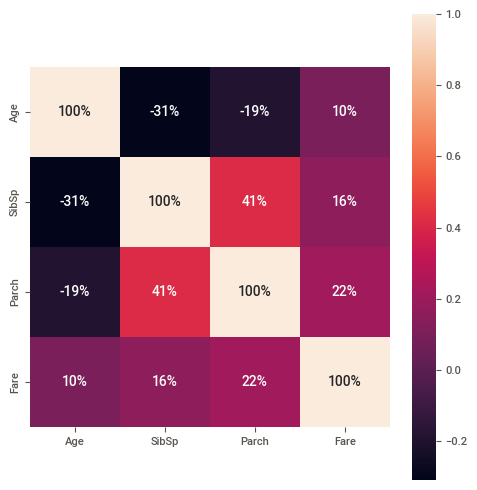

In [8]:
# quantitative associations
quantitative_df = train_set[quantitative_vars]
corr = quantitative_df.corr()
plt.figure(figsize=(5,5))
sns.heatmap(corr, fmt='.0%', annot=True, square=True)
plt.tight_layout()

In [9]:
# Compute VIF data for each independent variable
clean_quantitative_df = quantitative_df.dropna()
vif = pd.DataFrame()
vif["features"] = clean_quantitative_df.columns
vif["vif_Factor"] = [variance_inflation_factor(clean_quantitative_df.values, i) for i in range(clean_quantitative_df.shape[1])]
vif.sort_values(by=['vif_Factor'], ascending=False, inplace=True)
vif

,features,vif_Factor
3,Fare,1.535595
2,Parch,1.483994
1,SibSp,1.438954
0,Age,1.434323


The variables are not highly correlated, which implies that the presence of multicollinearity will not be an obstacle for us.

#### One qualitative and one quantitative variable

Here the idea is to check the correlation between the qualitative and quantitative variable (the target) to see if the qualitative variables have a high influence in the target.

To find this, we can use visualization methods, statistical measures, Anova or t-test.

In this case, one of the most commonly used hypothesis tests is the t-test, which is used to compare the means of two groups. The t-test is used to determine whether the difference between the means of two groups is statistically significant. Statistical significance refers to the likelihood that the difference between the means is not due to chance. If the difference is statistically significant, it means that there is a high probability that the difference is real and not just due to random variation.

This is a test for the null hypothesis that 2 independent samples have identical average (expected) values. This test assumes that the populations have identical variances by default.

In the specific case of this project, many of the distributions of quantitative variables do not follow a normal distribution, which is a premise of a t-test. In this case, an alternative to the t-test is the Mann-Whitney test, which is a non-parametric test that also compares the median between two groups and does not assume a specific data distribution.

The quantitative variable is: Age
           min   max       mean         var        std
Survived                                              
0         1.00  74.0  30.626179  200.848698  14.172110
1         0.42  80.0  28.343690  223.530965  14.950952


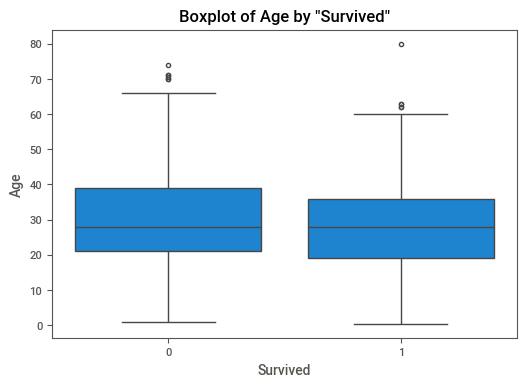

Mann-Whitney U test for Age:
Statistic: nan
P-value: nan
There is no statistically significant difference in the medians.
------------------------------------------------------------------------------------------
The quantitative variable is: SibSp
          min  max      mean       var       std
Survived                                        
0           0    8  0.553734  1.659972  1.288399
1           0    4  0.473684  0.502238  0.708688


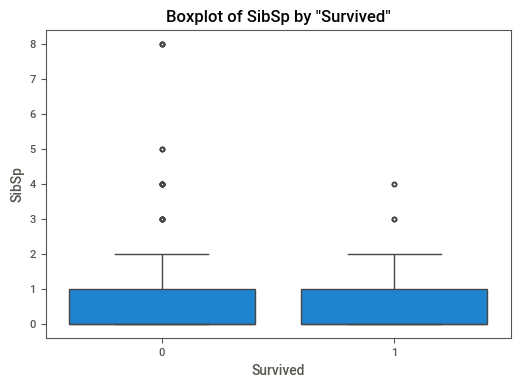

Mann-Whitney U test for SibSp:
Statistic: 101983.0
P-value: 0.008016684059168793
There is a statistically significant difference in the medians.
------------------------------------------------------------------------------------------
The quantitative variable is: Parch
          min  max      mean       var       std
Survived                                        
0           0    6  0.329690  0.677602  0.823166
1           0    5  0.464912  0.595539  0.771712


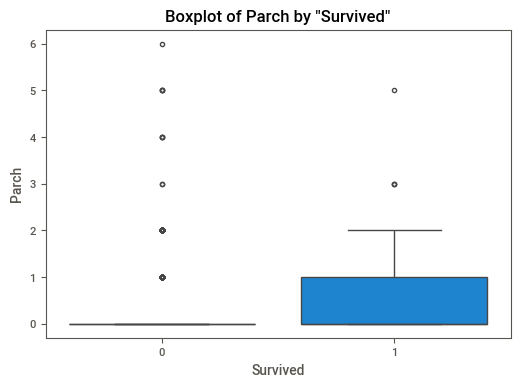

Mann-Whitney U test for Parch:
Statistic: 105373.0
P-value: 3.712490908378456e-05
There is a statistically significant difference in the medians.
------------------------------------------------------------------------------------------
The quantitative variable is: Fare
          min       max       mean          var        std
Survived                                                  
0         0.0  263.0000  22.117887   985.219509  31.388207
1         0.0  512.3292  48.395408  4435.160158  66.596998


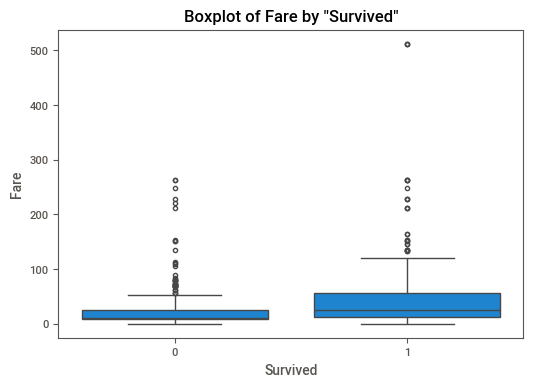

Mann-Whitney U test for Fare:
Statistic: 129951.5
P-value: 4.553477179250237e-22
There is a statistically significant difference in the medians.
------------------------------------------------------------------------------------------


In [10]:
# visualization and statistical measures approach
# Summary measures for quantitative independent features and label to search for relationships
for var in quantitative_vars:
    print('The quantitative variable is:', var)
    print(train_set.groupby('Survived')[var].agg(['min', 'max', 'mean', 'var', 'std']))
    
    # Create a boxplot
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='Survived', y=var, data=train_set)
    plt.title(f'Boxplot of {var} by "Survived"')
    plt.xlabel('Survived')
    plt.ylabel(var)
    plt.show()
    
    # Perform the Mann-Whitney U test
    group1 = train_set[train_set['Survived'] == 1][var]
    group2 = train_set[train_set['Survived'] == 0][var]
    statistic, p_value = stats.mannwhitneyu(group1, group2)
    
    # Print the results of the Mann-Whitney U test
    print(f'Mann-Whitney U test for {var}:')
    print(f'Statistic: {statistic}')
    print(f'P-value: {p_value}')
    
    if p_value < 0.05:  # Define an appropriate significance level
        print('There is a statistically significant difference in the medians.')
    else:
        print('There is no statistically significant difference in the medians.')
    
    print('------------------------------------------------------------------------------------------')

## Preprocessing

Based on what we have seen in exploratory data analysis, we gonna make some transformations in the data to be able to fit them in the gradient boost model.

In [11]:
# select only the features that we are going to use
X = train_set.drop(['Survived'], axis=1)
y = train_set['Survived']

In [12]:
class DropVariables(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_delete):
        self.columns_to_delete = columns_to_delete

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(self.columns_to_delete, axis=1)
    
    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return None
        return [feat for feat in input_features if feat not in self.columns_to_delete]

In [13]:
features_to_drop = [
    'PassengerId',
    'Name',
    'Ticket',
    'Cabin'
]

In [14]:
qualitative_preproc = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(drop='first', handle_unknown='ignore'))

quantitative_preproc = make_pipeline(
    SimpleImputer(strategy='constant', fill_value=-1))

drop_features_preproc = make_pipeline(
    DropVariables(features_to_drop))

preprocessor = ColumnTransformer([
    ('features_to_drop', drop_features_preproc, features_to_drop),
    ('qualitative_preproc', qualitative_preproc, qualitative_features_enconding),
    ('quantitative_preproc', quantitative_preproc, quantitative_features)],
    remainder='passthrough')

## Gradient Boosting

A very popular boosting algorithm is gradient boosting. Gradient boosting sequentially adds predictors to a set, each correcting its predecessor. This method tries to adjust the new predictor to the residual errors made by the previous predictor.

Let's look at a simple regression example, using decision trees as base predictors:

* tree_reg1 = DecisionTreeRegressor(max_depth=2)
* tree_reg1.fit(X, y)

We will then train a second DecisionTreeRegressor on the residual errors made by the first predictor:

* y2 = y - tree_reg1.predict(X)
* tree_reg2 = DecisionTreeRegressor(max_depth=2)
* tree_reg2.fit(X, y2)

Then, we will train a third regressor on the residual errors made by the second predictor:

* y3 = y2 - tree_reg2.predict(X)
* tree_reg3 = DecisionTreeRegressor(max_depth=2)
* tree_reg3.fit(X, y3)

Now, we have a cluster with 3 trees. It can make predictions on a new instance by simply adding the predictions from all trees:

* y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

Each tree is nudging the approximation closer and closer to the real target value.

In [15]:
# baseline that predicts only the majority class
baseline = 1 - y.mean()
baseline

0.6161616161616161

In [16]:
def run_classifier_models(X, y, cv, scoring):
    '''Function that trains the following machine learning models:
    RandomForestClassifier, DecisionTreeClassifier, SGDClassifier, SVC,
    LGBMClassifier, GaussianNB.
    The function applies cross-validation on the dataset and returns the average
    of the selected metric on the training and validation sets.
    The only active metrics are Accuracy and F1 score.
    Experiments with the models are logged with MLflow.
    
    :param X: (dataframe or numpy array) 
    Dataframe or array with the independent variables.
    
    :param y: (series or numpy array)
    Column or array with the dependent variable.
    
    :param cv: (int)
    Determines the cross-validation splitting strategy.
    
    :param scoring: (str)
    Strategy to evaluate the model's performance on the validation set during cross-validation.
    Should be passed within quotes when calling the function.
    '''
    # Instantiate the models
    gb = Pipeline(
        steps=[('preprocessor', preprocessor), 
               ('gb', GradientBoostingClassifier(n_estimators=10, random_state=42))]
    )
    scores = cross_validate(gb, X, y, return_train_score=True,
                            scoring=scoring, cv=cv, return_estimator=True)

    # train and validation with accuracy
    if scoring == 'accuracy':
        log_train_acc = np.mean(scores['train_score'])
        log_test_acc = np.mean(scores['test_score'])
        mean_train = log_train_acc.mean()
        mean_test = log_test_acc.mean()
        std_train = log_train_acc.std()
        std_test = log_test_acc.std()

    # train and validation with f1
    if scoring == 'f1':
        log_train_f1 = np.mean(scores['train_score'])
        log_test_f1 = np.mean(scores['test_score'])
        mean_train = log_train_f1.mean()
        mean_test = log_test_f1.mean()
        std_train = log_train_f1.std()
        std_test = log_test_f1.std()

    # Create final dataset
    df_result = pd.DataFrame(
        {'MEAN_TRAIN_SCORES': mean_train, 
         'MEAN_TEST_SCORES': mean_test, 'STD_TRAIN_SCORES': std_train, 
         'STD_TEST_SCORES': std_test}, index=[0])

    return df_result

In [17]:
# Run classifiers
df_result = run_classifier_models(X, y, 5, 'accuracy')
df_result

,MEAN_TRAIN_SCORES,MEAN_TEST_SCORES,STD_TRAIN_SCORES,STD_TEST_SCORES
0,0.820426,0.799102,0.0,0.0


We have a bit of overfitting but the model seems to perform well.

## Hyperparameter tuning

In [18]:
# Hyperparameter tunning
# 1. Instantiate the pipeline
final_model = Pipeline(
    steps=[
        ('preprocessor', preprocessor), 
        ('gb', GradientBoostingClassifier(n_estimators=10, random_state=42))
    ]
)

# 2. Hyperparameter interval to be tested
param_grid = {
    'gb__max_depth': [1, 2, 3],
    # 'dt__max_features': [1, 2, 3, 4, 5, 6, 7, 8, None],
    'gb__max_leaf_nodes': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None]
} # you should try as many values as possible, but to illustrate we gonna put a heavy weight

# 3. Training and apply grid search with cross validation
grid_search = GridSearchCV(final_model, param_grid, cv = 5, scoring = 'accuracy',
                           return_train_score = True)
grid_search.fit(X, y)

# Seeing the best hyperparameters for the model
print('The best hyperparameters were:', grid_search.best_params_)

The best hyperparameters were: {'gb__max_depth': 3, 'gb__max_leaf_nodes': 5}


In [19]:
cvres = grid_search.cv_results_
cvres = [(mean_test_score,
            mean_train_score) for mean_test_score,
            mean_train_score in sorted(zip(cvres['mean_test_score'],
                                        cvres['mean_train_score']),
                                    reverse=True) if (math.isnan(mean_test_score) != True)]
print(
    'The mean test score and mean train score is, respectively:',
    cvres[0])

The mean test score and mean train score is, respectively: (0.7991023790094784, 0.8204264304962414)


We were unable to improve accuracy or reduce overfitting, as that is not the objective here, let's move on!

## Global Interpretation

Global explanation = feature importance

To quantify feature importance, we need two things:

* A metric to quantify the gain at each split.
* A way to calculate the feature gain across all trees in the ensemble.

In gradient boosting machines, we look at all the trees as if they were one massive tree together.

### Feature importance

In [20]:
global_exp = pd.DataFrame()

gb = grid_search.best_estimator_.named_steps['gb']
global_exp['feature_importances'] = gb.feature_importances_
global_exp.index = grid_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out()

global_exp

,feature_importances
qualitative_preproc__Embarked_Q,0.000000
qualitative_preproc__Embarked_S,0.016074
qualitative_preproc__Sex_male,0.693128
quantitative_preproc__Age,0.003626
quantitative_preproc__SibSp,0.000000
quantitative_preproc__Parch,0.008220
quantitative_preproc__Fare,0.079224
remainder__Pclass,0.199728


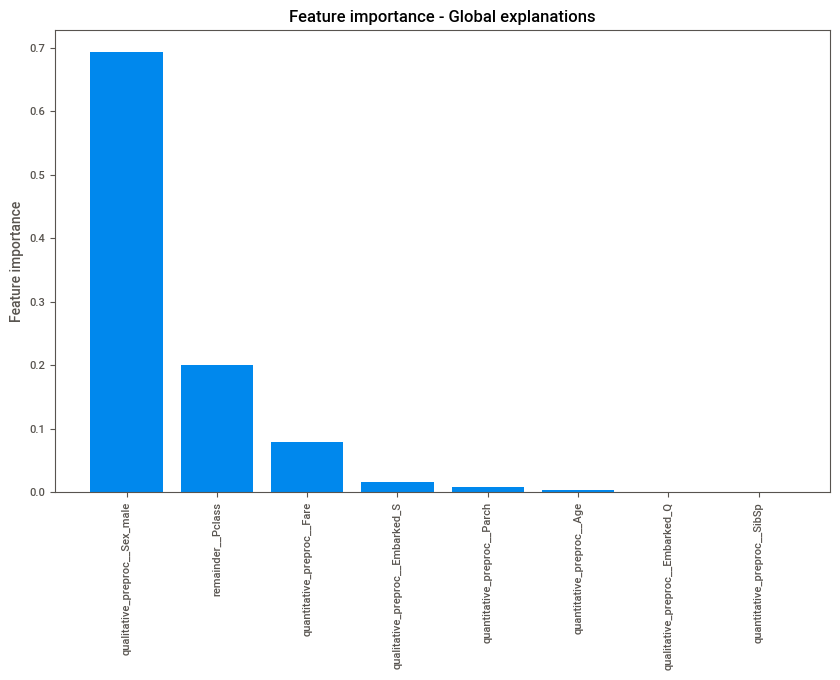

In [21]:
# Sort the DataFrame by the 'feature_importances' column in descending order and plot it
global_exp_sorted = global_exp.sort_values(by='feature_importances', ascending=False)
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(global_exp_sorted.index, global_exp_sorted['feature_importances'])
plt.ylabel("Feature importance")
plt.title("Feature importance - Global explanations")
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

Above the calculated importance of each variable.

## Conclusion

**Credits**

https://www.trainindata.com/